<a href="https://colab.research.google.com/github/jclauss24/MLTSA25_JClauss/blob/main/In_Class_Code/3_03_ARIMA_choose_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pylab as pl
import glob
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
import json
import os

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/fbb.mplstyle")

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive//MLTSA25/HW3/Stocks

/content/gdrive/MyDrive/MLTSA25/HW3/Stocks


In [ ]:
allfiles = np.sort(np.array(glob.glob('*.txt')))
allfiles

array(['a.us.txt', 'aa.us.txt', 'aaap.us.txt', ..., 'zx.us.txt',
       'zyme.us.txt', 'zyne.us.txt'], dtype='<U16')

# Part 1: data ingestion, exploration, preparation
#...continuing on from HW...


# ...

In [ ]:
allfiles.sort()

In [ ]:
allfiles[:10]

array(['a.us.txt', 'aa.us.txt', 'aaap.us.txt', 'aaba.us.txt',
       'aac.us.txt', 'aal.us.txt', 'aamc.us.txt', 'aame.us.txt',
       'aan.us.txt', 'aaoi.us.txt'], dtype='<U16')

In [ ]:
# use glob to sort the files alphabetically
alltss = []

tss = pd.read_csv(allfiles[0])[["Date", "Close"]].rename({"Close":
              allfiles[0].replace(".txt",
                                  "").replace("Data/Stocks/",  "")}, axis=1)

for f in allfiles[1:10]:
    print(f)
    name = f.replace(".txt","").replace("Data/Stocks/", "")

    tss = tss.merge(pd.read_csv(f)[["Date", "Close"]].rename({"Close":
                                                             name},
                                        axis=1), on="Date")
tss
#tss.rename(columns = {'Close':'Close_aaap'}, inplace = True) #For some reason, it doesnt like adding _aaap to the data for that stock. This line forces it to do that
tss.set_index("Date", inplace = True)


aa.us.txt
aaap.us.txt
aaba.us.txt
aac.us.txt
aal.us.txt
aamc.us.txt
aame.us.txt
aan.us.txt
aaoi.us.txt


In [ ]:
tss

,a.us,aa.us,aaap.us,aaba.us,aac.us,aal.us,aamc.us,aame.us,aan.us,aaoi.us
Date,,,,,,,,,,
2015-11-11,36.901,17.779,24.50,33.38,22.56,43.524,20.75,4.7960,24.649,16.76
2015-11-12,36.734,17.206,25.00,33.23,22.50,43.044,19.17,4.8951,24.182,16.11
2015-11-13,36.030,17.581,25.26,32.19,22.68,42.603,17.50,4.6672,23.795,16.60
2015-11-16,36.577,18.242,25.02,32.94,22.58,41.994,15.58,4.8455,23.923,16.93
2015-11-17,37.607,18.197,24.62,32.86,22.52,41.473,12.59,4.9150,23.418,16.68
...,...,...,...,...,...,...,...,...,...,...
2017-11-02,68.130,47.460,81.00,70.51,10.02,47.257,88.00,3.6500,35.800,39.28
2017-11-03,68.370,47.120,80.99,70.23,10.08,47.346,80.40,3.6000,36.430,37.82
2017-11-07,68.250,46.970,81.00,72.22,11.07,46.358,81.00,3.4000,34.440,37.89


## testing for stationarity (you did it in HW2 but it will be useful have it here under your eyes)
test if each of these time series is stationary using the AD fuller test using ```statsmodels.api.tsa.stattools.adfuller()```

```for f in tss.columns:
    sm.tsa.stattools.adfuller(tss[c])```

Have the code automatically print a statement about wheather the ts is stationary for each ts (for example in a for loop).

In [ ]:
threshold = 0.05 # always choose the threshold first (good science to avoid bias)
print ("Stationarity results from the AD Fuller test at a p-value of 0.05")
for c in tss.columns:
    print(c, "is stationary:", sm.tsa.stattools.adfuller(tss[c])[1] < threshold)

Stationarity results from the AD Fuller test at a p-value of 0.05
a.us is stationary: False
aa.us is stationary: False
aaap.us is stationary: False
aaba.us is stationary: False
aac.us is stationary: False
aal.us is stationary: False
aamc.us is stationary: False
aame.us is stationary: True
aan.us is stationary: False
aaoi.us is stationary: False


# 1. Question: why did I set the threshold to 0.05? what does 0.05 mean?
The threshold 0.05 is commonly accepted as the alpha value in a statistical test. you are willing to accept a 5% change that the data is this extreme, given random varation. Generally, this is a low enough chance to be sure that the data come from different distributions. 5% also represents two standard deviations.

# MODELING FLOW STARTS HERE: measure autocorrelation

plot the time series and its autocorrelation and partial autocorrelation function in blue if it is not stationary, in red if it is stationary

As a reminder, the plotting function for the autocorrelation and partial autocorelation functions works as follows

In [ ]:
column_name = "aame.us"
STATIONARY = True

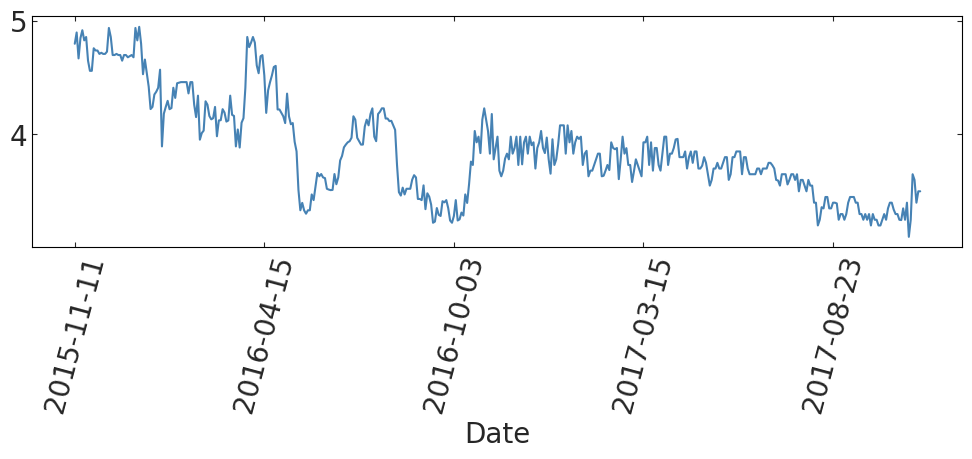

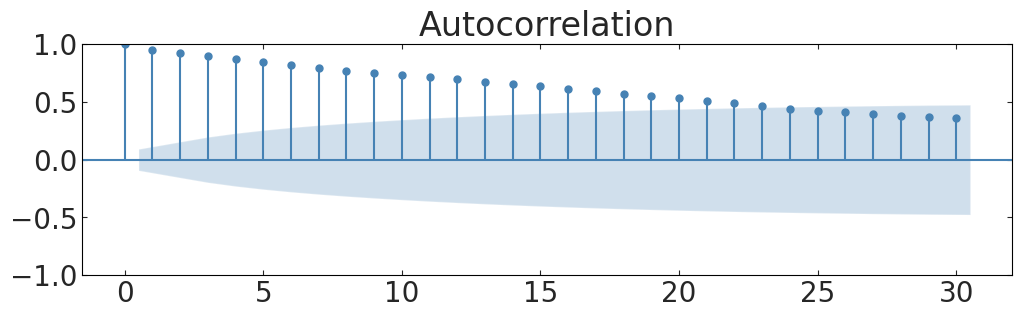

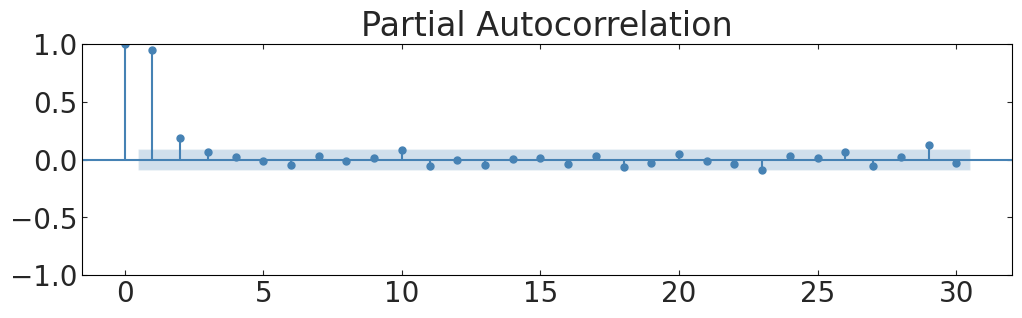

In [ ]:
iorder = 0 if STATIONARY else 1
tss[column_name].plot(rot=75, figsize=(12,3));
ax = pl.figure(figsize=(12,3)).add_subplot(111)
sm.graphics.tsa.plot_acf(tss[column_name], lags=30, ax=ax)
ax = pl.figure(figsize=(12,3)).add_subplot(111)
fig = sm.graphics.tsa.plot_pacf(tss[column_name], lags=30, ax=ax);

Fig 4: ...

note that the 6th (or 7th) lag have a significant correlation (for aaap)

for aaame (the one thats stationary) only the first 2 lags are significant.


# 3. Question: pick one of the time series (of your choice) and tell me which lags are expected to be significant in the model based on the ACF and PACF plots you made
I have chosen to plot the 'aa' closing time. Based on the auto-correlation function and the partial-auto-correlation function, I believe that up to 30 lags of the ACF are significant and 2 of the partial ACF are significant. To save on computation time, I will only account for 2 lags for p and q.

# training and testing split
To set up a training and test set for this, remove the last two months of data (60 days) and use it as a test set. Were your predictions good enough to make you rich? Predict 100 days forward of the training set

you do not have to overthink it and create differnt variables, you can simply select data without the last 2 month when you pass the data to the fit function. Here, make a plot of the first time series plotting in blue the training data and in orange the test data

In [ ]:
train_set = tss[column_name][:-60]
test_set = tss[column_name][-60:]


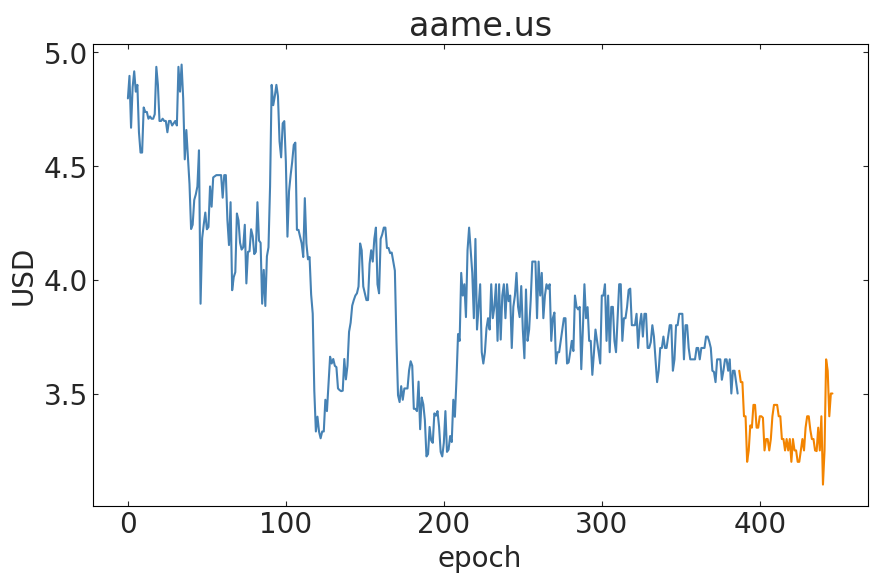

In [ ]:
pl.plot(np.arange(tss.shape[0] - 60), tss.loc[:,column_name][:-60])
pl.plot(np.arange(tss.shape[0] - 60, tss.shape[0]), tss.loc[:,column_name][-60:]);
pl.title(column_name)
pl.xlabel("epoch")
pl.ylabel("USD");

# Part 2: Model and Forecast
Here we are doing sock price analysis. The most likely reason is that we want to make $$$ - so we want to forecast the future.


To fit the model to the data use ```statsmodels.api.tsa.ARMA```

You can inspect the function call as ```statsmodels.api.tsa.ARMA?```
The statsmodels models are generally fit into 2 phases: generating the model ```sm.tsa.ARMA(data, parameters)```, and then fitting it ```sm.tsa.ARMA(data, parameters).fit()```.

To look at the model result, including the AIC,  look at the model summary ```mod.summary()``` What are the best fit parameters based on this printed summary and thewir uncertainties? What is the value of the AIC(Aikiki Information Criterion)

See https://github.com/fedhere/MLTSA22_FBianco/CodeExamples/ARMA/testingARMA_ARIMA.ipynb



In [ ]:
model = sm.tsa.ARIMA(endog = train_set, order = (1, iorder, 1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                aame.us   No. Observations:                  387
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 249.303
Date:                Tue, 04 Mar 2025   AIC                           -490.605
Time:                        20:12:16   BIC                           -474.772
Sample:                             0   HQIC                          -484.327
                                - 387                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9933      0.175     22.761      0.000       3.649       4.337
ar.L1          0.9765      0.013     75.095      0.000       0.951       1.002
ma.L1         -0.2624      0.044     -5.968      0.000      -0.349      -0.176
sigma2         0.0160      0.001     19.434      0.000       0.014       0.018
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                73.64
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
mod = sm.tsa.ARIMA(endog = train_set, order=(2, iorder, 2)).fit()

#(tss[c], (3,1), dates=tss["Date"], ).fit()
#mod.plot_predict(dynamic=True, plot_insample=False)
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                aame.us   No. Observations:                  387
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 249.303
Date:                Tue, 04 Mar 2025   AIC                           -486.607
Time:                        20:12:43   BIC                           -462.856
Sample:                             0   HQIC                          -477.189
                                - 387                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9934      0.176     22.629      0.000       3.648       4.339
ar.L1          1.0789     30.788      0.035      0.972     -59.264      61.421
ar.L2         -0.0999     30.066     -0.003      0.997     -59.028      58.828
ma.L1         -0.3644     30.786     -0.012      0.991     -60.704      59.976
ma.L2          0.0250      8.093      0.003      0.998     -15.837      15.887
sigma2         0.0160      0.001     19.280      0.000       0.014       0.018
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                73.75
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#example of model output
mod = sm.tsa.ARIMA(endog = train_set, order=(3, iorder, 3)).fit()

#(tss[c], (3,1), dates=tss["Date"], ).fit()
#mod.plot_predict(dynamic=True, plot_insample=False)
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                aame.us   No. Observations:                  387
Model:                 ARIMA(3, 0, 3)   Log Likelihood                 250.561
Date:                Tue, 04 Mar 2025   AIC                           -485.121
Time:                        20:12:49   BIC                           -453.454
Sample:                             0   HQIC                          -472.564
                                - 387                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9489      0.193     20.473      0.000       3.571       4.327
ar.L1         -0.1348      0.379     -0.355      0.722      -0.878       0.609
ar.L2          0.4129      0.222      1.857      0.063      -0.023       0.849
ar.L3          0.6597      0.306      2.156      0.031       0.060       1.259
ma.L1          0.8622      0.371      2.323      0.020       0.135       1.590
ma.L2          0.4218      0.243      1.737      0.082      -0.054       0.898
ma.L3         -0.2047      0.078     -2.629      0.009      -0.357      -0.052
sigma2         0.0157      0.001     19.002      0.000       0.014       0.017
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                79.96
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#example of how you could set a for loop to save the AIC values for each model
from tqdm import tqdm #this lets us see progress bars as the loops run
aics = {}
aics = np.zeros((7,7))
for p in tqdm(range(1,8), desc='Outer loop', position=0, leave=True):
    for q in tqdm(range(1,8), desc='\tInner loop', position=1, leave=False):
      aics[p-1,q-1] = sm.tsa.ARIMA(train_set, order=(p, iorder, q)).fit().aic

print("\n\nbest parameters: ", np.where(aics == np.nanmin(aics)))


Outer loop: 100%|██████████| 7/7 [02:26<00:00, 20.92s/it]



best parameters:  (array([0]), array([0]))


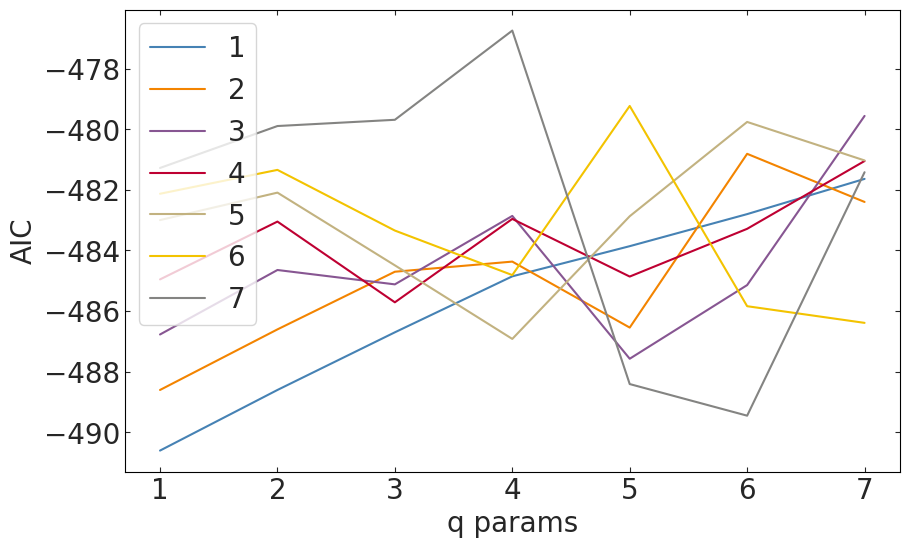

In [ ]:
plt.plot(range(1,8), aics, label=[f"{x}" for x in range(1,8)]);
plt.xlabel("q params")
plt.ylabel("AIC")
plt.legend();

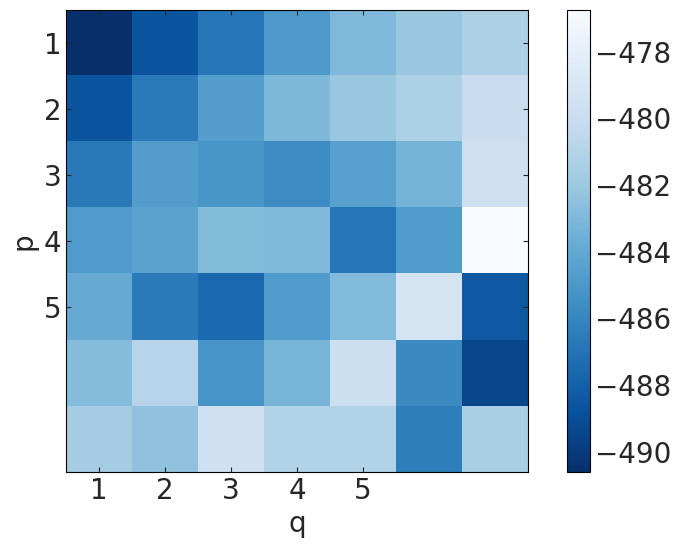

In [ ]:
plt.imshow(aics, cmap="Blues_r")
plt.xlabel("q")
plt.ylabel("p")
plt.xticks(list(range(0,5)), list(range(1,6)))
plt.yticks(list(range(0,5)), list(range(1,6)))
plt.colorbar();

Naively, we choose the model with the lowest AIC.

AIC is designed to start going up at increased parameters.

at low number of parameters, the log liklihood will dominate.

We want to choose when the model stops improving rapidly.

## 6. Task: predict the in-set (training) and the future values


In [ ]:
train_set

,aame.us
Date,
2015-11-11,4.7960
2015-11-12,4.8951
2015-11-13,4.6672
2015-11-16,4.8455
2015-11-17,4.9150
...,...
2017-07-25,3.5000
2017-07-26,3.6000
2017-07-27,3.6000


In [ ]:
prediction

NameError: name 'prediction' is not defined

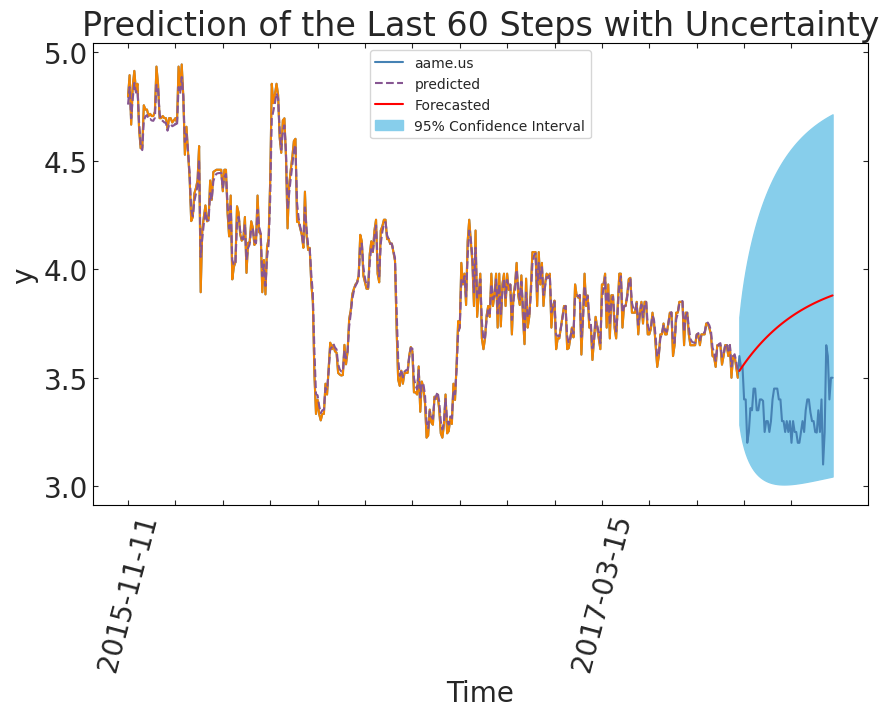

In [ ]:

ax = tss[[column_name]].plot()
bestmodel = sm.tsa.ARIMA(train_set, order=(1, iorder, 1)).fit()

ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

plt.plot(tss.iloc[:-60].index, train_set)#, rot=75, lw=2)

prediction = bestmodel.predict(start=1, end=len(train_set))
plt.plot(tss.iloc[:-60].index, prediction, '--', label="predicted")

forecast = bestmodel.get_forecast(60)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)

# Plot the predictions with uncertainty
plt.plot(tss.iloc[-60:].index, yhat, label="Forecasted", color="red")
plt.fill_between(tss.iloc[-60:].index,  yhat_conf_int["lower " + column_name],
                 yhat_conf_int["upper " + column_name],
                 color="skyblue",
                 label="95% Confidence Interval")
plt.xticks(tss.index[::30], rotation=75)
plt.xlabel("Time")
plt.ylabel("y")
plt.title("Prediction of the Last 60 Steps with Uncertainty")
plt.legend(fontsize=10)
#plt.xlim(tss.index[0], tss.index[10])
#plt.xlim(tss.index[-65], tss.index[-55])
plt.show()

